# CIFAR10 Classification
In this notebook I'm going to implement a Convolutional Neural Network (CNN) using pytorch and train it on the Cifar10 classification problem and achieve 91.43 percent (using k-fold cross validation with k=10) and 92.72 (highest accuracy) percent (without using k-fold and validation set) accuracy on the test.

so in this Notebook, there are two approaches for training a CNN, one with k-fold cross-validation and one without it, as the second approach provides more data to feed to the model (in the case of k=10, this extra amount is about 5000 samples), it will reach more accuracy on the test dataset than the first approach.

The first cell contains the code for importing the needed libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay



import torch
from torch import nn
from torch.utils.data import DataLoader

from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, SubsetRandomSampler, ConcatDataset
from torchinfo import summary

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor


plt.style.use('ggplot')

In [2]:
DATA_PATH = 'D:\PyTorch_datasets'
BATCH_SIZE = 256

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Load and preprocessing dataset

I applied some transformation techniques on training dataset in order to improve the generalization of model. 

In [44]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

train_tfms = transforms.Compose([transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize(*stats, inplace=True)])
valid_tfms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(*stats, inplace=True)])

load the train and test datasets.

In [45]:
cifar10_train_data = datasets.CIFAR10(
    root=DATA_PATH,
    train=True,
    download=True,
    transform=train_tfms,    # how do we want to transform the data
    target_transform=None    # how do we want to transform the labels/targets
)

cifar10_test_data = datasets.CIFAR10(
    root=DATA_PATH,
    train=False,
    download=True,
    transform=valid_tfms,
    target_transform=None
)

Files already downloaded and verified
Files already downloaded and verified


In [50]:
cifar10_train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: D:\PyTorch_datasets
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )

In [46]:
len(cifar10_train_data), len(cifar10_test_data)

(50000, 10000)

In [47]:
class_names = cifar10_train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

#### Visualizing train data
visualize some samples of the train dataset to have grasp of what type of data we're dealing with

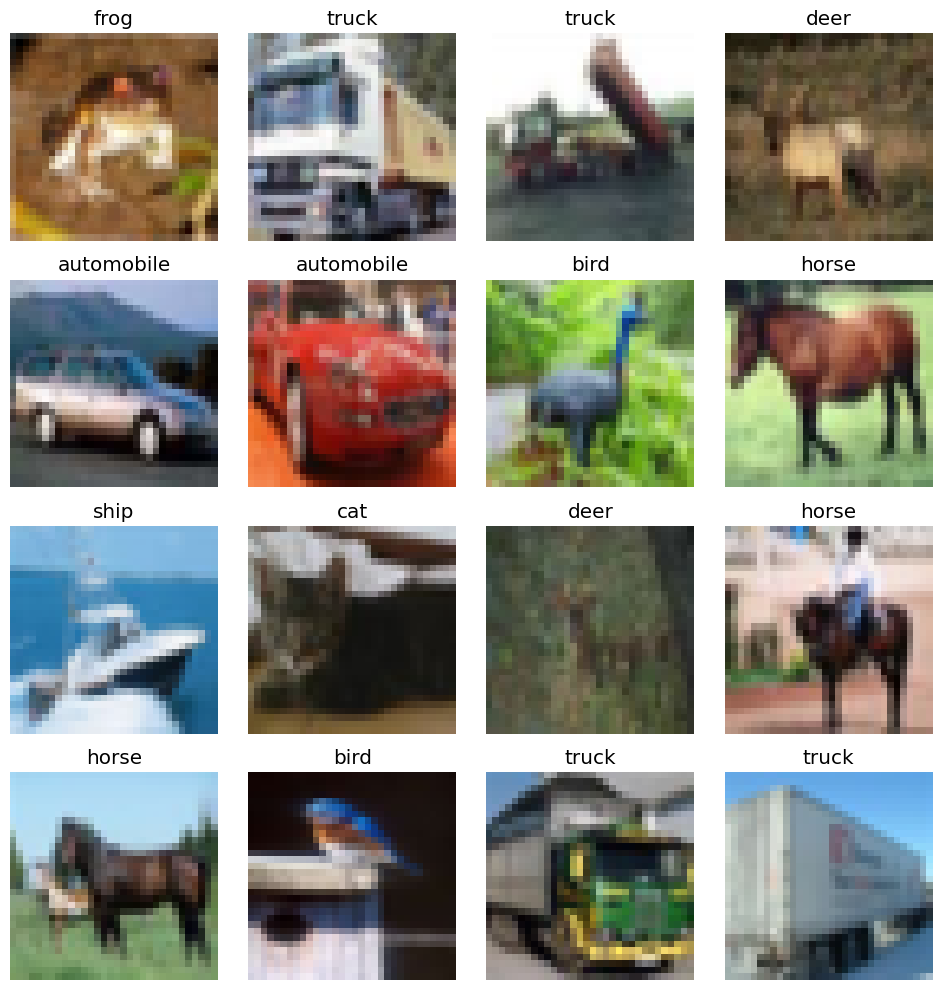

In [275]:
plt.figure(figsize=(10, 10))
rows = 4
columns = 4
for i in range(columns):
    for j in range(rows):
        plt.subplot(rows, columns, i*rows+j+1)
        plt.imshow(cifar10_train_data.data[i*rows+j])
        plt.title(class_names[cifar10_train_data.targets[i*rows+j]])
        plt.axis('off')
        plt.tight_layout()

In [49]:
train_dataloader = DataLoader(cifar10_train_data, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(cifar10_test_data, batch_size=BATCH_SIZE)

## Implement the model architecture

In this notebook, I'm using a resnet-like architecture as my main model. The total parameters of this model is  770,346. the exact architecture of the network is provided with the help of the `summary` function in the following cells.

In [333]:
def conv_block(in_channels, out_channels, kernel_size=3, padding=1, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: 
        layers.append(nn.MaxPool2d(2))
        
    return nn.Sequential(*layers)

class Classifier(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 32)
        self.res1 = nn.Sequential(conv_block(32, 32), conv_block(32, 32))
        self.conv2 = conv_block(32, 32)
        self.res2 = nn.Sequential(conv_block(32, 32), conv_block(32, 32))
        self.conv3 = conv_block(32, 64, pool=True)
        self.res3 = nn.Sequential(conv_block(64, 64), conv_block(64, 64))
        self.conv4 = conv_block(64, 64)
        self.res4 = nn.Sequential(conv_block(64, 64), conv_block(64, 64))
        self.conv5 = conv_block(64, 128, pool=True)
        self.res5 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.conv6 = conv_block(128, 128, pool=True)
        
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
#                                         nn.Dropout(p=0.4),
                                        nn.Linear(128, num_classes))
        
    def forward(self, x):
#         inp = x 
#         print(x.shape)
#         x1 = self.conv1_1(x)
        x = self.conv1(x)
        x = self.res1(x) + x
        x = self.conv2(x)
        x = self.res2(x) + x
        x = self.conv3(x)
        x = self.res3(x) + x
        x = self.conv4(x)
        x = self.res4(x) + x
        x = self.conv5(x)
        x = self.res5(x) + x
        x = self.conv6(x)

        x = self.classifier(x)
#         print(x.shape)
        return x

In [334]:
m = Classifier(3, 10).to(device)
summary(m)

Layer (type:depth-idx)                   Param #
Classifier10                             --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       896
│    └─BatchNorm2d: 2-2                  64
│    └─ReLU: 2-3                         --
├─Sequential: 1-2                        --
│    └─Sequential: 2-4                   --
│    │    └─Conv2d: 3-1                  9,248
│    │    └─BatchNorm2d: 3-2             64
│    │    └─ReLU: 3-3                    --
│    └─Sequential: 2-5                   --
│    │    └─Conv2d: 3-4                  9,248
│    │    └─BatchNorm2d: 3-5             64
│    │    └─ReLU: 3-6                    --
├─Sequential: 1-3                        --
│    └─Conv2d: 2-6                       9,248
│    └─BatchNorm2d: 2-7                  64
│    └─ReLU: 2-8                         --
├─Sequential: 1-4                        --
│    └─Sequential: 2-9                   --
│    │    └─Conv2d: 3-7                  9,248
│    │    └─Ba

## Definintions

The following cell contains the definition of a function that given an optimizer, returns the current value of its learning rate. this function will be used in other functions that their role is performing the whole train and testing procedures (one with k-fold and one without it).

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

The following function performs the whole process of training/testing (without using k-fold cross-validation or validation set) procedure in a given number of epochs. the techniques used to improve the accuracy and generalization of the model:

- weight decay (L2 penalty)
- using the `OneCycleLR` learning rate scheduler
- gradient clipping

finally, for visualization purposes, this function returns some values (such as accuracies and losses on train and test).

In [377]:
def train_and_test_without_kfold(epochs, max_lr, model, loss_function, train_loader, val_loader, 
                                 weight_decay=0, grad_clip=None, opt_func=torch.optim.Adam, device = device):

    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0005, nesterov=True)
    # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3, 8, 13, 17], gamma=0.3)
    # scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.001, step_size_up=3, mode='triangular2', cycle_momentum=False)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-5)
    
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20)

    max_acc = 0
    lrs = []
    accs_on_train = []
    losses_on_train = []
    accs_on_validation = []
    losses_on_validation = []

    
    for epoch in range(epochs):
        print(f"Epoch: {epoch}\n-------")
        
        train_loss, train_acc = 0, 0
        model.train()

        for batch, (X, y) in tqdm(enumerate(train_loader)):
            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            loss = loss_function(y_pred, y)
            train_loss += loss    

            predicted_labels = torch.softmax(y_pred, dim=1).argmax(dim=1)
            correct = torch.eq(y, predicted_labels).sum().item()
            train_acc += (correct / len(predicted_labels)) * 100

            optimizer.zero_grad()

            loss.backward()

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            
            lrs.append(get_lr(optimizer))
            scheduler.step()
            # print(f'{batch}: train loss', loss)

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
        
        test_loss, test_acc, labels, preds = test_epoch(model, val_loader, loss_function, device, set_name='Test')

        losses_on_train.append(float(train_loss))
        accs_on_train.append(float(train_acc))
        losses_on_validation.append(float(test_loss))
        accs_on_validation.append(float(test_acc))
        
    return losses_on_train, accs_on_train, losses_on_validation, accs_on_validation, labels, preds, lrs

The following function does the same thing as the last function (performs the whole process of training/testing) but the main difference is that it uses k-fold cross-validation (and therefore the evaluation set) with k=10 to train the model. The techniques used to improve the accuracy and generalization of the model are the same as the last function:

- weight decay (L2 penalty)
- using the `OneCycleLR` learning rate scheduler
- gradient clipping

finally, for visualization purposes, this function returns some values (such as accuracies and losses on train and validation sets).

In [350]:
def train_and_test_kfold(epochs, max_lr, model, loss_function, cifar10_train_data, cifar10_test_data, 
                    weight_decay=0, grad_clip=None, opt_func=torch.optim.Adam, device = device):

    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=176)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-5)
    # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3, 8, 13, 17], gamma=0.3)


    test_dataloader = DataLoader(cifar10_test_data, batch_size=BATCH_SIZE)

    k=10
    splits=KFold(n_splits=k,shuffle=False)#,random_state=42)
    

    max_acc = 0
    
    accs_on_train = []
    losses_on_train = []
    accs_on_validation = []
    losses_on_validation = []
    model.train()
    epoch = 0
    lrs = []
    # i = 0
    
    while epoch < epochs:
    
        for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(len(cifar10_train_data)))):
            
            train_loss, train_acc = 0, 0

            print(f'Epoch: {epoch}  Fold {fold + 1}\n-------')
            
            train_sampler = SubsetRandomSampler(train_idx)
            val_sampler = SubsetRandomSampler(val_idx)

            train_dataloader = DataLoader(cifar10_train_data, batch_size=BATCH_SIZE, sampler=train_sampler)
            val_dataloader = DataLoader(cifar10_train_data, batch_size=BATCH_SIZE, sampler=val_sampler)
        
            for batch, (X, y) in tqdm(enumerate(train_dataloader)):
                X, y = X.to(device), y.to(device)
    
                y_pred = model(X)
    
                loss = loss_function(y_pred, y)
                train_loss += loss    
    
                predicted_labels = torch.softmax(y_pred, dim=1).argmax(dim=1)
                correct = torch.eq(y, predicted_labels).sum().item()
                train_acc += (correct / len(predicted_labels)) * 100
    
                optimizer.zero_grad()
    
                loss.backward()
    
                if grad_clip:
                    nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
                optimizer.step()
                
                lrs.append(get_lr(optimizer))
                scheduler.step()
    
            
        
            train_loss /= len(train_dataloader)
            train_acc /= len(train_dataloader)
    
            print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    
            val_loss, val_acc, _, _ = test_epoch(model, val_dataloader, loss_function, device, set_name='Validation')

            losses_on_train.append(float(train_loss))
            accs_on_train.append(float(train_acc))
            losses_on_validation.append(float(val_loss))
            accs_on_validation.append(float(val_acc))
    
            epoch += 1
            if epoch >= epochs:
                break
        
    
    # if (i > 15) and (test_acc > max_acc):
    #     checkpoint = {
    #         'epoch': epoch,
    #         'model': res_model.state_dict(),
    #         'optimizer': optimizer.state_dict(),
    #         'lr_sched': scheduler
    #     }
    #     torch.save(checkpoint, f'class5_checkpoint({test_acc}_acc).pth')
    #     print(f'saving model on epoch:{epoch}')
    #     max_acc = test_acc
    # i += 1

        val_loss, val_acc, labels, preds = test_epoch(model, test_dataloader, loss_function, device, set_name='Test')

    return losses_on_train, accs_on_train, losses_on_validation, accs_on_validation, labels, preds, lrs


The `test_epoch` function will be used in `train_and_test_kfold` and `train_and_test_without_kfold` functions to perform one epoch of testing on a dataloader and return the results.

In [247]:
def test_epoch(model, data_loader, loss_fn, device=device, set_name='Validation'):
    
    test_loss, test_acc = 0, 0
    
    model.eval()
    labels, preds = np.array([]), np.array([])
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            
            test_pred = model(X)
            predicted_labels = torch.softmax(test_pred, dim=1).argmax(dim=1)
            correct = torch.eq(y, predicted_labels).sum().item()
            test_acc += (correct / len(predicted_labels)) * 100
            
            preds = np.concatenate((preds, predicted_labels.cpu().numpy()))
            labels = np.concatenate((labels, y.cpu().numpy()))
            
            test_loss += loss_fn(test_pred, y)
            
            
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        
        print(f"{set_name} loss: {test_loss:.5f} | {set_name} accuracy: {test_acc:.2f}%\n")
        return test_loss, test_acc, labels, preds

The following function will visualize some of the wrong classified images by our model, in the test dataset. 

In [361]:
def plot_some_mistakes(dataset, labels, preds, class_names):
    number_of_plots = 32
    ncols = 4
    nrows = 8

    plt.figure(figsize=(9, 18))


    torch.manual_seed(2)
    images = dataset.data[labels != preds]
    random_idx = np.random.choice(images.shape[0], number_of_plots)
    selected_labels = labels[labels != preds]
    selected_preds = preds[labels != preds]

    for i in range(len(random_idx)):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(images[i])
        pred_label = class_names[int(selected_preds[i])]
        true_label = class_names[int(selected_labels[i])]

        title_text = f" Pred: {pred_label} | True label: {true_label}"

        plt.title(title_text, fontsize=8, c='k')
        plt.axis(False)
        plt.tight_layout()


## Implement and train the models

#### With K-fold cross-validation

In the following, I'm going to implement my model and set some hyperparameters for the trainig procedure, and I'm using `Adam` optimizer for this problem.

In [351]:
epochs = 100
max_lr = 0.01
grad_clip = 0.1 
weight_decay = 1e-4
opt_func = torch.optim.Adam

loss_function = nn.CrossEntropyLoss()

res_model = Classifier(3, 10).to(device)

In [352]:
summary(res_model)

Layer (type:depth-idx)                   Param #
Classifier10                             --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       896
│    └─BatchNorm2d: 2-2                  64
│    └─ReLU: 2-3                         --
├─Sequential: 1-2                        --
│    └─Sequential: 2-4                   --
│    │    └─Conv2d: 3-1                  9,248
│    │    └─BatchNorm2d: 3-2             64
│    │    └─ReLU: 3-3                    --
│    └─Sequential: 2-5                   --
│    │    └─Conv2d: 3-4                  9,248
│    │    └─BatchNorm2d: 3-5             64
│    │    └─ReLU: 3-6                    --
├─Sequential: 1-3                        --
│    └─Conv2d: 2-6                       9,248
│    └─BatchNorm2d: 2-7                  64
│    └─ReLU: 2-8                         --
├─Sequential: 1-4                        --
│    └─Sequential: 2-9                   --
│    │    └─Conv2d: 3-7                  9,248
│    │    └─Ba

As said before, I'm going to pursue two approachs for trainig my model, one with cross-validation and one without it. in the following cell I'm going to implement the first approach (with k-fold cross-validation)

In [353]:
train_losses, train_accs, val_losses, val_accs, labels, preds, lrs = train_and_test_kfold(epochs, max_lr, res_model, loss_function, cifar10_train_data, 
                                                                                          cifar10_test_data, grad_clip=grad_clip, weight_decay=weight_decay, 
                                                                                          opt_func=opt_func)

Epoch: 0  Fold 1
-------


176it [10:15,  3.50s/it]


Train loss: 1.50176 | Train accuracy: 45.40%
Validation loss: 1.18547 | Validation accuracy: 57.92%

Epoch: 1  Fold 2
-------


176it [10:03,  3.43s/it]


Train loss: 1.33134 | Train accuracy: 52.20%
Validation loss: 1.15679 | Validation accuracy: 57.48%

Epoch: 2  Fold 3
-------


176it [10:03,  3.43s/it]


Train loss: 1.03633 | Train accuracy: 63.24%
Validation loss: 0.96918 | Validation accuracy: 66.16%

Epoch: 3  Fold 4
-------


176it [09:54,  3.38s/it]


Train loss: 0.91286 | Train accuracy: 67.66%
Validation loss: 0.99437 | Validation accuracy: 64.61%

Epoch: 4  Fold 5
-------


176it [10:04,  3.43s/it]


Train loss: 0.84069 | Train accuracy: 70.52%
Validation loss: 0.78135 | Validation accuracy: 72.71%

Epoch: 5  Fold 6
-------


176it [10:04,  3.43s/it]


Train loss: 0.78717 | Train accuracy: 72.59%
Validation loss: 0.66364 | Validation accuracy: 77.09%

Epoch: 6  Fold 7
-------


176it [10:03,  3.43s/it]


Train loss: 0.71229 | Train accuracy: 75.28%
Validation loss: 0.74502 | Validation accuracy: 74.39%

Epoch: 7  Fold 8
-------


176it [10:04,  3.43s/it]


Train loss: 0.68188 | Train accuracy: 76.48%
Validation loss: 0.68232 | Validation accuracy: 75.87%

Epoch: 8  Fold 9
-------


176it [10:03,  3.43s/it]


Train loss: 0.64476 | Train accuracy: 77.99%
Validation loss: 0.66150 | Validation accuracy: 77.21%

Epoch: 9  Fold 10
-------


176it [10:04,  3.43s/it]


Train loss: 0.62521 | Train accuracy: 78.27%
Validation loss: 0.62969 | Validation accuracy: 77.45%

Test loss: 0.63417 | Test accuracy: 78.47%

Epoch: 10  Fold 1
-------


176it [10:04,  3.44s/it]


Train loss: 0.62401 | Train accuracy: 78.55%
Validation loss: 0.58606 | Validation accuracy: 79.98%

Epoch: 11  Fold 2
-------


176it [10:04,  3.43s/it]


Train loss: 0.61641 | Train accuracy: 78.81%
Validation loss: 0.66224 | Validation accuracy: 76.84%

Epoch: 12  Fold 3
-------


176it [10:04,  3.43s/it]


Train loss: 0.60411 | Train accuracy: 79.16%
Validation loss: 0.69084 | Validation accuracy: 76.12%

Epoch: 13  Fold 4
-------


176it [10:03,  3.43s/it]


Train loss: 0.60302 | Train accuracy: 79.15%
Validation loss: 0.63575 | Validation accuracy: 78.50%

Epoch: 14  Fold 5
-------


176it [10:04,  3.43s/it]


Train loss: 0.60325 | Train accuracy: 79.27%
Validation loss: 0.60285 | Validation accuracy: 79.63%

Epoch: 15  Fold 6
-------


176it [10:03,  3.43s/it]


Train loss: 0.57969 | Train accuracy: 80.10%
Validation loss: 0.56106 | Validation accuracy: 80.51%

Epoch: 16  Fold 7
-------


176it [10:04,  3.43s/it]


Train loss: 0.57165 | Train accuracy: 80.29%
Validation loss: 0.56578 | Validation accuracy: 80.41%

Epoch: 17  Fold 8
-------


176it [10:03,  3.43s/it]


Train loss: 0.54214 | Train accuracy: 81.36%
Validation loss: 0.55756 | Validation accuracy: 80.91%

Epoch: 18  Fold 9
-------


176it [10:03,  3.43s/it]


Train loss: 0.53573 | Train accuracy: 81.66%
Validation loss: 0.51963 | Validation accuracy: 81.93%

Epoch: 19  Fold 10
-------


176it [10:04,  3.43s/it]


Train loss: 0.51084 | Train accuracy: 82.48%
Validation loss: 0.56422 | Validation accuracy: 79.95%

Test loss: 0.56119 | Test accuracy: 80.57%

Epoch: 20  Fold 1
-------


176it [10:03,  3.43s/it]


Train loss: 0.50214 | Train accuracy: 82.72%
Validation loss: 0.47614 | Validation accuracy: 83.78%

Epoch: 21  Fold 2
-------


176it [10:03,  3.43s/it]


Train loss: 0.50325 | Train accuracy: 82.72%
Validation loss: 0.53062 | Validation accuracy: 81.49%

Epoch: 22  Fold 3
-------


176it [10:04,  3.43s/it]


Train loss: 0.49150 | Train accuracy: 83.04%
Validation loss: 0.46760 | Validation accuracy: 84.26%

Epoch: 23  Fold 4
-------


176it [10:04,  3.44s/it]


Train loss: 0.48870 | Train accuracy: 83.16%
Validation loss: 0.46204 | Validation accuracy: 84.10%

Epoch: 24  Fold 5
-------


176it [10:03,  3.43s/it]


Train loss: 0.47284 | Train accuracy: 83.72%
Validation loss: 0.49351 | Validation accuracy: 83.49%

Epoch: 25  Fold 6
-------


176it [10:03,  3.43s/it]


Train loss: 0.47543 | Train accuracy: 83.52%
Validation loss: 0.43501 | Validation accuracy: 84.24%

Epoch: 26  Fold 7
-------


176it [10:03,  3.43s/it]


Train loss: 0.47876 | Train accuracy: 83.62%
Validation loss: 0.47700 | Validation accuracy: 83.44%

Epoch: 27  Fold 8
-------


176it [10:04,  3.43s/it]


Train loss: 0.47341 | Train accuracy: 83.68%
Validation loss: 0.45235 | Validation accuracy: 85.00%

Epoch: 28  Fold 9
-------


176it [10:04,  3.43s/it]


Train loss: 0.47204 | Train accuracy: 83.76%
Validation loss: 0.48074 | Validation accuracy: 82.66%

Epoch: 29  Fold 10
-------


176it [10:03,  3.43s/it]


Train loss: 0.46662 | Train accuracy: 83.86%
Validation loss: 0.49852 | Validation accuracy: 82.61%

Test loss: 0.54420 | Test accuracy: 82.22%

Epoch: 30  Fold 1
-------


176it [10:04,  3.44s/it]


Train loss: 0.46044 | Train accuracy: 83.92%
Validation loss: 0.46962 | Validation accuracy: 84.23%

Epoch: 31  Fold 2
-------


176it [10:03,  3.43s/it]


Train loss: 0.45829 | Train accuracy: 84.23%
Validation loss: 0.48376 | Validation accuracy: 83.06%

Epoch: 32  Fold 3
-------


176it [10:03,  3.43s/it]


Train loss: 0.46118 | Train accuracy: 84.20%
Validation loss: 0.48101 | Validation accuracy: 83.77%

Epoch: 33  Fold 4
-------


176it [10:03,  3.43s/it]


Train loss: 0.46716 | Train accuracy: 83.94%
Validation loss: 0.48094 | Validation accuracy: 83.85%

Epoch: 34  Fold 5
-------


176it [10:00,  3.41s/it]


Train loss: 0.45979 | Train accuracy: 84.26%
Validation loss: 0.41329 | Validation accuracy: 85.60%

Epoch: 35  Fold 6
-------


176it [10:03,  3.43s/it]


Train loss: 0.46502 | Train accuracy: 84.03%
Validation loss: 0.43223 | Validation accuracy: 85.63%

Epoch: 36  Fold 7
-------


176it [10:04,  3.43s/it]


Train loss: 0.45554 | Train accuracy: 84.39%
Validation loss: 0.47677 | Validation accuracy: 83.93%

Epoch: 37  Fold 8
-------


176it [10:04,  3.43s/it]


Train loss: 0.45339 | Train accuracy: 84.52%
Validation loss: 0.47610 | Validation accuracy: 83.68%

Epoch: 38  Fold 9
-------


176it [10:03,  3.43s/it]


Train loss: 0.45697 | Train accuracy: 84.12%
Validation loss: 0.41397 | Validation accuracy: 85.69%

Epoch: 39  Fold 10
-------


176it [10:04,  3.43s/it]


Train loss: 0.44510 | Train accuracy: 84.51%
Validation loss: 0.41900 | Validation accuracy: 85.02%

Test loss: 0.44269 | Test accuracy: 84.94%

Epoch: 40  Fold 1
-------


176it [10:04,  3.43s/it]


Train loss: 0.44953 | Train accuracy: 84.62%
Validation loss: 0.44530 | Validation accuracy: 85.16%

Epoch: 41  Fold 2
-------


176it [10:03,  3.43s/it]


Train loss: 0.46135 | Train accuracy: 84.18%
Validation loss: 0.48844 | Validation accuracy: 82.44%

Epoch: 42  Fold 3
-------


176it [10:03,  3.43s/it]


Train loss: 0.44942 | Train accuracy: 84.41%
Validation loss: 0.45445 | Validation accuracy: 84.29%

Epoch: 43  Fold 4
-------


176it [10:04,  3.43s/it]


Train loss: 0.44200 | Train accuracy: 84.85%
Validation loss: 0.45063 | Validation accuracy: 84.21%

Epoch: 44  Fold 5
-------


176it [10:03,  3.43s/it]


Train loss: 0.44754 | Train accuracy: 84.69%
Validation loss: 0.47177 | Validation accuracy: 83.72%

Epoch: 45  Fold 6
-------


176it [10:04,  3.43s/it]


Train loss: 0.43718 | Train accuracy: 84.73%
Validation loss: 0.50482 | Validation accuracy: 82.91%

Epoch: 46  Fold 7
-------


176it [10:04,  3.43s/it]


Train loss: 0.44216 | Train accuracy: 84.75%
Validation loss: 0.51105 | Validation accuracy: 82.77%

Epoch: 47  Fold 8
-------


176it [10:04,  3.43s/it]


Train loss: 0.43760 | Train accuracy: 85.07%
Validation loss: 0.43193 | Validation accuracy: 85.01%

Epoch: 48  Fold 9
-------


176it [10:04,  3.43s/it]


Train loss: 0.42541 | Train accuracy: 85.27%
Validation loss: 0.44150 | Validation accuracy: 84.50%

Epoch: 49  Fold 10
-------


176it [10:03,  3.43s/it]


Train loss: 0.43181 | Train accuracy: 85.03%
Validation loss: 0.39106 | Validation accuracy: 85.88%

Test loss: 0.43304 | Test accuracy: 85.36%

Epoch: 50  Fold 1
-------


176it [10:04,  3.43s/it]


Train loss: 0.42534 | Train accuracy: 85.35%
Validation loss: 0.38341 | Validation accuracy: 86.48%

Epoch: 51  Fold 2
-------


176it [10:03,  3.43s/it]


Train loss: 0.41227 | Train accuracy: 85.83%
Validation loss: 0.41192 | Validation accuracy: 85.76%

Epoch: 52  Fold 3
-------


176it [10:03,  3.43s/it]


Train loss: 0.41614 | Train accuracy: 85.56%
Validation loss: 0.38728 | Validation accuracy: 86.97%

Epoch: 53  Fold 4
-------


176it [10:04,  3.43s/it]


Train loss: 0.38955 | Train accuracy: 86.62%
Validation loss: 0.43247 | Validation accuracy: 85.23%

Epoch: 54  Fold 5
-------


176it [10:04,  3.43s/it]


Train loss: 0.39423 | Train accuracy: 86.38%
Validation loss: 0.44159 | Validation accuracy: 85.22%

Epoch: 55  Fold 6
-------


176it [10:03,  3.43s/it]


Train loss: 0.38787 | Train accuracy: 86.62%
Validation loss: 0.36040 | Validation accuracy: 87.09%

Epoch: 56  Fold 7
-------


176it [10:03,  3.43s/it]


Train loss: 0.38358 | Train accuracy: 86.72%
Validation loss: 0.42810 | Validation accuracy: 85.01%

Epoch: 57  Fold 8
-------


176it [10:04,  3.43s/it]


Train loss: 0.37598 | Train accuracy: 87.09%
Validation loss: 0.36352 | Validation accuracy: 87.61%

Epoch: 58  Fold 9
-------


176it [10:03,  3.43s/it]


Train loss: 0.36915 | Train accuracy: 87.00%
Validation loss: 0.35461 | Validation accuracy: 87.33%

Epoch: 59  Fold 10
-------


176it [10:04,  3.43s/it]


Train loss: 0.37492 | Train accuracy: 86.98%
Validation loss: 0.37982 | Validation accuracy: 86.77%

Test loss: 0.43617 | Test accuracy: 85.16%

Epoch: 60  Fold 1
-------


176it [10:04,  3.43s/it]


Train loss: 0.35446 | Train accuracy: 87.72%
Validation loss: 0.35574 | Validation accuracy: 87.65%

Epoch: 61  Fold 2
-------


176it [10:03,  3.43s/it]


Train loss: 0.35384 | Train accuracy: 87.80%
Validation loss: 0.34952 | Validation accuracy: 87.96%

Epoch: 62  Fold 3
-------


176it [10:00,  3.41s/it]


Train loss: 0.33559 | Train accuracy: 88.31%
Validation loss: 0.36697 | Validation accuracy: 87.30%

Epoch: 63  Fold 4
-------


176it [10:05,  3.44s/it]


Train loss: 0.33561 | Train accuracy: 88.25%
Validation loss: 0.31707 | Validation accuracy: 89.43%

Epoch: 64  Fold 5
-------


176it [10:04,  3.43s/it]


Train loss: 0.33290 | Train accuracy: 88.37%
Validation loss: 0.35913 | Validation accuracy: 87.38%

Epoch: 65  Fold 6
-------


176it [10:00,  3.41s/it]


Train loss: 0.32011 | Train accuracy: 88.89%
Validation loss: 0.31992 | Validation accuracy: 88.58%

Epoch: 66  Fold 7
-------


176it [09:50,  3.35s/it]


Train loss: 0.30581 | Train accuracy: 89.27%
Validation loss: 0.33257 | Validation accuracy: 88.64%

Epoch: 67  Fold 8
-------


176it [10:05,  3.44s/it]


Train loss: 0.29691 | Train accuracy: 89.83%
Validation loss: 0.31145 | Validation accuracy: 89.20%

Epoch: 68  Fold 9
-------


176it [10:04,  3.43s/it]


Train loss: 0.28720 | Train accuracy: 89.92%
Validation loss: 0.29838 | Validation accuracy: 89.54%

Epoch: 69  Fold 10
-------


176it [10:04,  3.43s/it]


Train loss: 0.28553 | Train accuracy: 90.01%
Validation loss: 0.27035 | Validation accuracy: 90.50%

Test loss: 0.36375 | Test accuracy: 87.81%

Epoch: 70  Fold 1
-------


176it [10:04,  3.43s/it]


Train loss: 0.27747 | Train accuracy: 90.35%
Validation loss: 0.25295 | Validation accuracy: 91.11%

Epoch: 71  Fold 2
-------


176it [10:04,  3.44s/it]


Train loss: 0.26537 | Train accuracy: 90.69%
Validation loss: 0.26936 | Validation accuracy: 90.61%

Epoch: 72  Fold 3
-------


176it [10:04,  3.43s/it]


Train loss: 0.25345 | Train accuracy: 91.10%
Validation loss: 0.25692 | Validation accuracy: 91.18%

Epoch: 73  Fold 4
-------


176it [10:03,  3.43s/it]


Train loss: 0.24080 | Train accuracy: 91.66%
Validation loss: 0.26676 | Validation accuracy: 91.08%

Epoch: 74  Fold 5
-------


176it [10:04,  3.43s/it]


Train loss: 0.23626 | Train accuracy: 91.65%
Validation loss: 0.24392 | Validation accuracy: 91.69%

Epoch: 75  Fold 6
-------


176it [10:04,  3.43s/it]


Train loss: 0.22225 | Train accuracy: 92.34%
Validation loss: 0.22400 | Validation accuracy: 92.32%

Epoch: 76  Fold 7
-------


176it [10:04,  3.43s/it]


Train loss: 0.21361 | Train accuracy: 92.44%
Validation loss: 0.24537 | Validation accuracy: 91.28%

Epoch: 77  Fold 8
-------


176it [10:04,  3.43s/it]


Train loss: 0.20282 | Train accuracy: 92.91%
Validation loss: 0.21116 | Validation accuracy: 92.18%

Epoch: 78  Fold 9
-------


176it [10:04,  3.43s/it]


Train loss: 0.19607 | Train accuracy: 92.99%
Validation loss: 0.18787 | Validation accuracy: 93.24%

Epoch: 79  Fold 10
-------


176it [10:04,  3.43s/it]


Train loss: 0.17881 | Train accuracy: 93.71%
Validation loss: 0.17445 | Validation accuracy: 94.02%

Test loss: 0.30816 | Test accuracy: 89.76%

Epoch: 80  Fold 1
-------


176it [10:03,  3.43s/it]


Train loss: 0.17052 | Train accuracy: 94.08%
Validation loss: 0.15168 | Validation accuracy: 94.78%

Epoch: 81  Fold 2
-------


176it [09:57,  3.39s/it]


Train loss: 0.15872 | Train accuracy: 94.44%
Validation loss: 0.15879 | Validation accuracy: 94.20%

Epoch: 82  Fold 3
-------


176it [10:00,  3.41s/it]


Train loss: 0.14930 | Train accuracy: 94.70%
Validation loss: 0.15579 | Validation accuracy: 94.45%

Epoch: 83  Fold 4
-------


176it [10:03,  3.43s/it]


Train loss: 0.14083 | Train accuracy: 95.01%
Validation loss: 0.15147 | Validation accuracy: 94.73%

Epoch: 84  Fold 5
-------


176it [10:03,  3.43s/it]


Train loss: 0.13351 | Train accuracy: 95.18%
Validation loss: 0.12446 | Validation accuracy: 95.71%

Epoch: 85  Fold 6
-------


176it [10:04,  3.44s/it]


Train loss: 0.12289 | Train accuracy: 95.67%
Validation loss: 0.11730 | Validation accuracy: 95.80%

Epoch: 86  Fold 7
-------


176it [10:02,  3.43s/it]


Train loss: 0.11526 | Train accuracy: 95.84%
Validation loss: 0.12599 | Validation accuracy: 95.29%

Epoch: 87  Fold 8
-------


176it [10:02,  3.42s/it]


Train loss: 0.10840 | Train accuracy: 96.22%
Validation loss: 0.09647 | Validation accuracy: 96.58%

Epoch: 88  Fold 9
-------


176it [10:02,  3.42s/it]


Train loss: 0.09767 | Train accuracy: 96.54%
Validation loss: 0.08285 | Validation accuracy: 97.22%

Epoch: 89  Fold 10
-------


176it [10:02,  3.42s/it]


Train loss: 0.09036 | Train accuracy: 96.81%
Validation loss: 0.09002 | Validation accuracy: 96.65%

Test loss: 0.31245 | Test accuracy: 91.28%

Epoch: 90  Fold 1
-------


176it [09:58,  3.40s/it]


Train loss: 0.08382 | Train accuracy: 97.05%
Validation loss: 0.08913 | Validation accuracy: 96.81%

Epoch: 91  Fold 2
-------


176it [10:03,  3.43s/it]


Train loss: 0.07830 | Train accuracy: 97.27%
Validation loss: 0.07902 | Validation accuracy: 97.34%

Epoch: 92  Fold 3
-------


176it [10:04,  3.43s/it]


Train loss: 0.07379 | Train accuracy: 97.41%
Validation loss: 0.07323 | Validation accuracy: 97.40%

Epoch: 93  Fold 4
-------


176it [10:03,  3.43s/it]


Train loss: 0.07204 | Train accuracy: 97.46%
Validation loss: 0.06929 | Validation accuracy: 97.49%

Epoch: 94  Fold 5
-------


176it [10:03,  3.43s/it]


Train loss: 0.06472 | Train accuracy: 97.78%
Validation loss: 0.06898 | Validation accuracy: 97.61%

Epoch: 95  Fold 6
-------


176it [10:03,  3.43s/it]


Train loss: 0.06303 | Train accuracy: 97.82%
Validation loss: 0.05520 | Validation accuracy: 98.13%

Epoch: 96  Fold 7
-------


176it [10:03,  3.43s/it]


Train loss: 0.06107 | Train accuracy: 97.93%
Validation loss: 0.07034 | Validation accuracy: 97.61%

Epoch: 97  Fold 8
-------


176it [10:02,  3.42s/it]


Train loss: 0.06089 | Train accuracy: 97.86%
Validation loss: 0.05746 | Validation accuracy: 98.10%

Epoch: 98  Fold 9
-------


176it [10:02,  3.42s/it]


Train loss: 0.05983 | Train accuracy: 97.96%
Validation loss: 0.05413 | Validation accuracy: 98.21%

Epoch: 99  Fold 10
-------


176it [10:04,  3.43s/it]


Train loss: 0.05807 | Train accuracy: 98.00%
Validation loss: 0.06046 | Validation accuracy: 98.03%

Test loss: 0.31834 | Test accuracy: 91.43%



saving the trained model

In [360]:
torch.save(res_model.state_dict(), "kfold_100_epoch_checkpoint(91.43_acc).pth")

plot loss and accuracy on train and validation sets

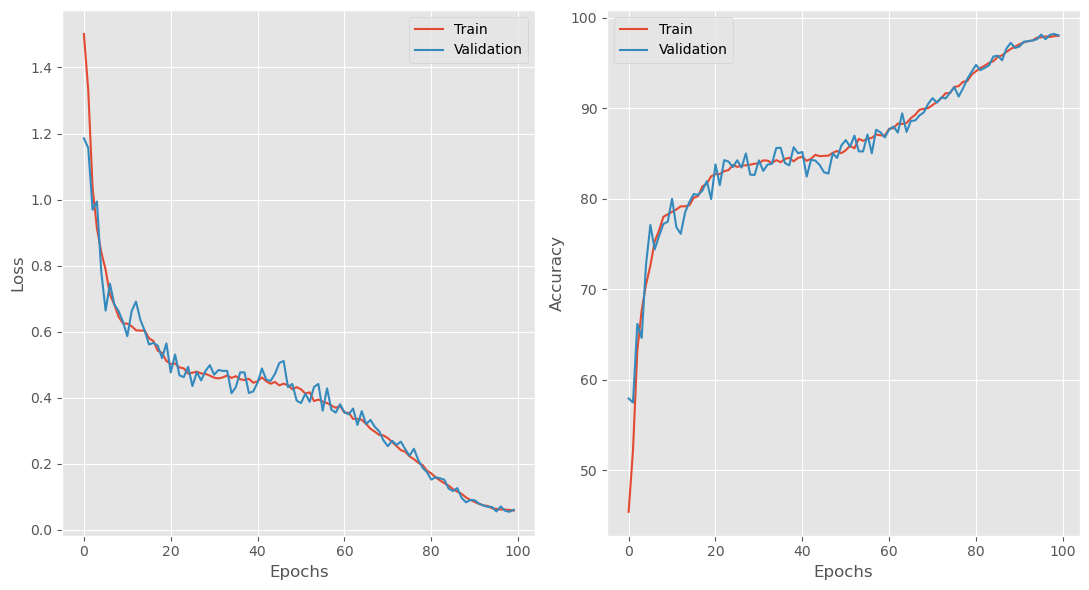

In [354]:
plt.figure(figsize=(11, 6))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses, label='Train')
plt.plot(range(len(val_losses)), val_losses, label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(train_accs)), train_accs, label='Train')
plt.plot(range(len(val_accs)), val_accs, label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.tight_layout()

Plot the values of learning rate values during the training process

Text(0, 0.5, 'learning rate value')

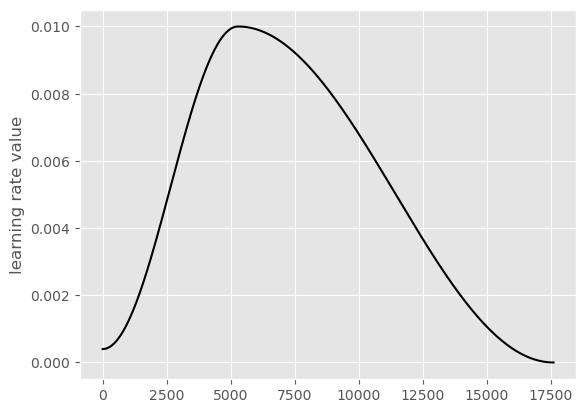

In [394]:
plt.plot(range(len(lrs)), lrs, c='k')
plt.ylabel('learning rate value')

Plotting the confusion matrix of results of the first approach

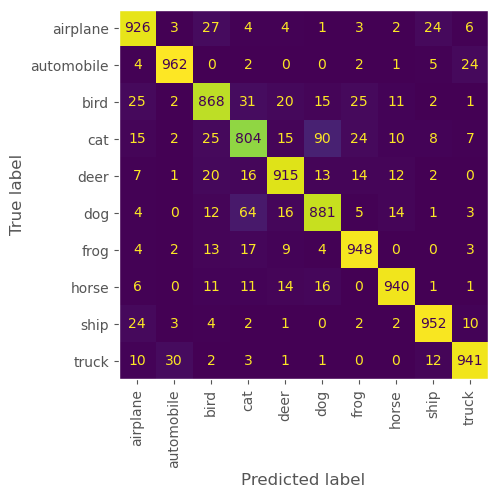

In [355]:
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=np.array(class_names))
disp.plot(xticks_rotation='vertical', colorbar=False)#, cmap='Blues')
plt.grid(False)

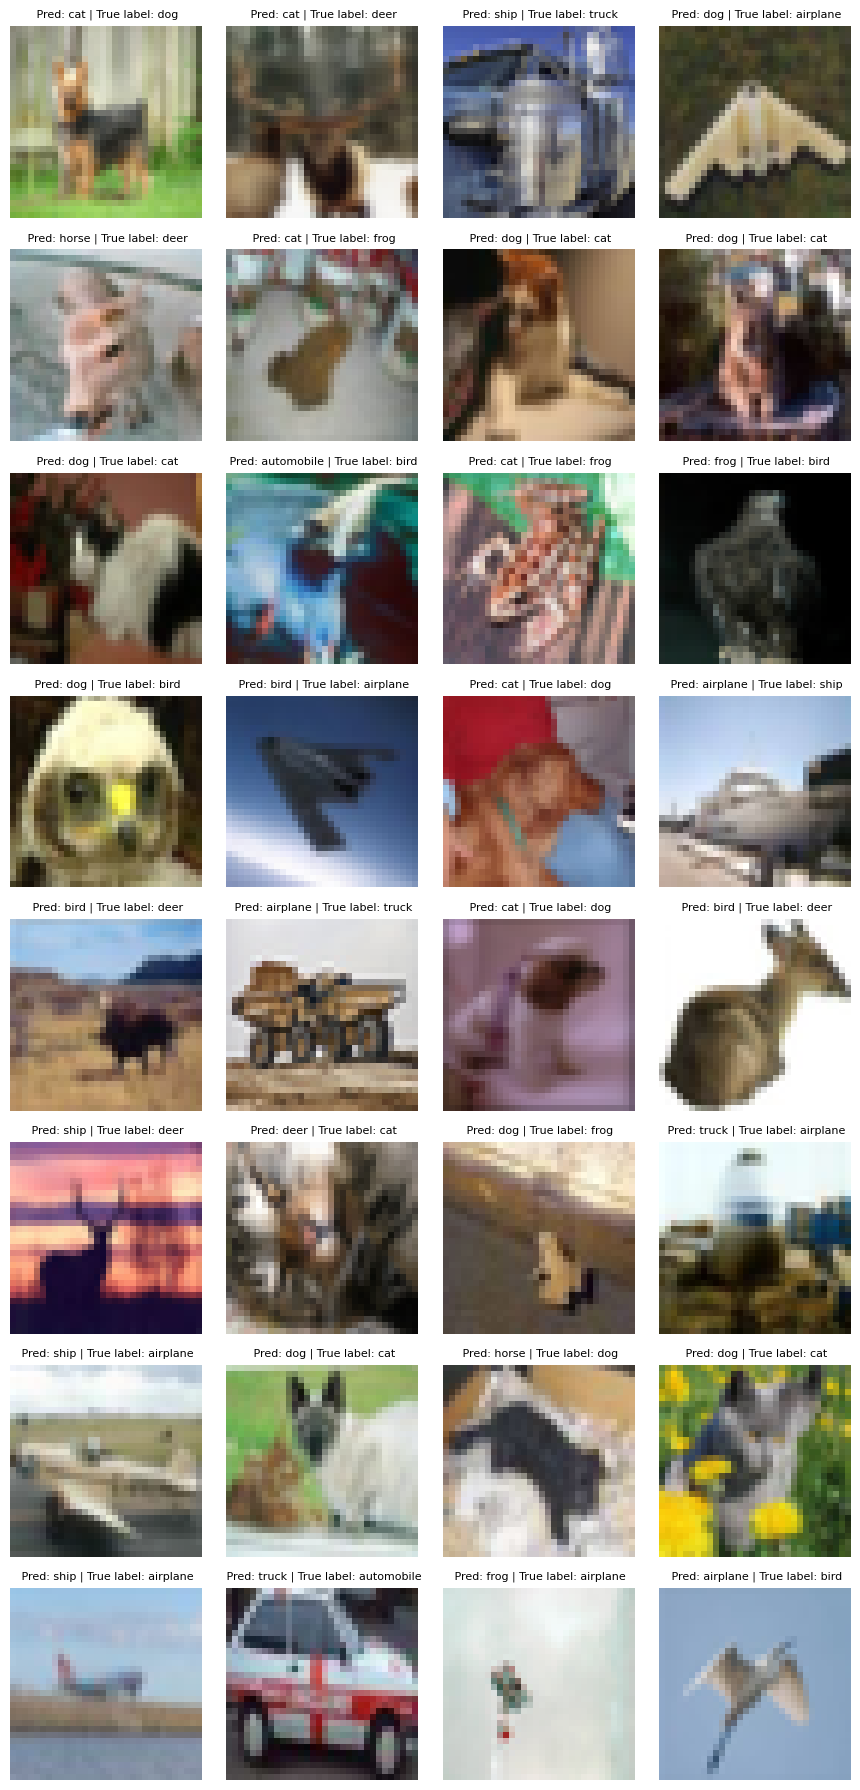

In [357]:
plot_some_mistakes(cifar10_test_data, labels, preds, class_names)

#### Without K-fold cross-validation

On the following cells, the second approach (without k-fold or validation dataset) will be implemented.

In [382]:
epochs = 100
max_lr = 0.01
grad_clip = 0.1 
weight_decay = 1e-4
opt_func = torch.optim.Adam

loss_function = nn.CrossEntropyLoss()

res_model_without_kfold = Classifier(3, 10).to(device)

In [383]:
train_losses, train_accs, val_losses, val_accs, labels, preds, lrs = train_and_test_without_kfold(epochs, max_lr, res_model_without_kfold, loss_function, train_dataloader, 
                                                                                                  test_dataloader, grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

Epoch: 0
-------


176it [10:17,  3.51s/it]


Train loss: 1.48464 | Train accuracy: 46.32%
Test loss: 1.25607 | Test accuracy: 54.49%

Epoch: 1
-------


176it [10:17,  3.51s/it]


Train loss: 0.97822 | Train accuracy: 65.18%
Test loss: 0.93540 | Test accuracy: 66.77%

Epoch: 2
-------


176it [10:17,  3.51s/it]


Train loss: 0.77769 | Train accuracy: 72.41%
Test loss: 0.78405 | Test accuracy: 72.21%

Epoch: 3
-------


176it [10:16,  3.50s/it]


Train loss: 0.66079 | Train accuracy: 77.08%
Test loss: 0.67658 | Test accuracy: 77.03%

Epoch: 4
-------


176it [10:16,  3.50s/it]


Train loss: 0.58580 | Train accuracy: 79.69%
Test loss: 0.79130 | Test accuracy: 73.59%

Epoch: 5
-------


176it [10:15,  3.49s/it]


Train loss: 0.53908 | Train accuracy: 81.30%
Test loss: 0.81456 | Test accuracy: 73.07%

Epoch: 6
-------


176it [10:14,  3.49s/it]


Train loss: 0.49835 | Train accuracy: 83.09%
Test loss: 0.78729 | Test accuracy: 73.68%

Epoch: 7
-------


176it [10:13,  3.49s/it]


Train loss: 0.47405 | Train accuracy: 83.66%
Test loss: 0.59121 | Test accuracy: 80.58%

Epoch: 8
-------


176it [10:15,  3.50s/it]


Train loss: 0.44471 | Train accuracy: 84.80%
Test loss: 0.67375 | Test accuracy: 78.62%

Epoch: 9
-------


176it [10:15,  3.49s/it]


Train loss: 0.42533 | Train accuracy: 85.34%
Test loss: 0.56170 | Test accuracy: 81.23%

Epoch: 10
-------


176it [10:15,  3.50s/it]


Train loss: 0.42281 | Train accuracy: 85.38%
Test loss: 0.63271 | Test accuracy: 79.95%

Epoch: 11
-------


176it [10:15,  3.49s/it]


Train loss: 0.39772 | Train accuracy: 86.15%
Test loss: 0.91010 | Test accuracy: 71.70%

Epoch: 12
-------


176it [10:15,  3.50s/it]


Train loss: 0.38664 | Train accuracy: 86.71%
Test loss: 0.57282 | Test accuracy: 80.56%

Epoch: 13
-------


176it [10:15,  3.49s/it]


Train loss: 0.37848 | Train accuracy: 87.00%
Test loss: 0.55245 | Test accuracy: 82.47%

Epoch: 14
-------


176it [10:14,  3.49s/it]


Train loss: 0.37374 | Train accuracy: 86.98%
Test loss: 0.59586 | Test accuracy: 80.64%

Epoch: 15
-------


176it [10:15,  3.50s/it]


Train loss: 0.36309 | Train accuracy: 87.49%
Test loss: 0.55688 | Test accuracy: 81.61%

Epoch: 16
-------


176it [10:14,  3.49s/it]


Train loss: 0.36428 | Train accuracy: 87.48%
Test loss: 0.56414 | Test accuracy: 81.14%

Epoch: 17
-------


176it [10:14,  3.49s/it]


Train loss: 0.35579 | Train accuracy: 87.77%
Test loss: 0.66464 | Test accuracy: 79.33%

Epoch: 18
-------


176it [10:15,  3.49s/it]


Train loss: 0.36044 | Train accuracy: 87.53%
Test loss: 0.61359 | Test accuracy: 80.13%

Epoch: 19
-------


176it [10:15,  3.49s/it]


Train loss: 0.35361 | Train accuracy: 87.77%
Test loss: 0.47775 | Test accuracy: 83.93%

Epoch: 20
-------


176it [10:15,  3.49s/it]


Train loss: 0.36279 | Train accuracy: 87.47%
Test loss: 0.56469 | Test accuracy: 81.79%

Epoch: 21
-------


176it [10:15,  3.49s/it]


Train loss: 0.35836 | Train accuracy: 87.64%
Test loss: 0.60352 | Test accuracy: 81.13%

Epoch: 22
-------


176it [10:15,  3.49s/it]


Train loss: 0.36642 | Train accuracy: 87.41%
Test loss: 0.60944 | Test accuracy: 80.05%

Epoch: 23
-------


176it [10:15,  3.50s/it]


Train loss: 0.37007 | Train accuracy: 87.15%
Test loss: 0.64405 | Test accuracy: 79.32%

Epoch: 24
-------


176it [10:15,  3.49s/it]


Train loss: 0.36867 | Train accuracy: 87.29%
Test loss: 0.66056 | Test accuracy: 78.96%

Epoch: 25
-------


176it [10:15,  3.49s/it]


Train loss: 0.36951 | Train accuracy: 87.25%
Test loss: 0.48187 | Test accuracy: 84.30%

Epoch: 26
-------


176it [10:14,  3.49s/it]


Train loss: 0.36878 | Train accuracy: 87.32%
Test loss: 0.56143 | Test accuracy: 81.44%

Epoch: 27
-------


176it [10:15,  3.50s/it]


Train loss: 0.38039 | Train accuracy: 86.94%
Test loss: 0.53501 | Test accuracy: 82.18%

Epoch: 28
-------


176it [10:15,  3.49s/it]


Train loss: 0.37933 | Train accuracy: 87.05%
Test loss: 0.63468 | Test accuracy: 79.17%

Epoch: 29
-------


176it [10:11,  3.47s/it]


Train loss: 0.38201 | Train accuracy: 86.84%
Test loss: 0.58417 | Test accuracy: 79.90%

Epoch: 30
-------


176it [10:15,  3.50s/it]


Train loss: 0.38749 | Train accuracy: 86.51%
Test loss: 0.77892 | Test accuracy: 76.29%

Epoch: 31
-------


176it [10:14,  3.49s/it]


Train loss: 0.38188 | Train accuracy: 86.65%
Test loss: 0.58651 | Test accuracy: 80.41%

Epoch: 32
-------


176it [10:14,  3.49s/it]


Train loss: 0.38123 | Train accuracy: 86.87%
Test loss: 0.52023 | Test accuracy: 82.16%

Epoch: 33
-------


176it [10:14,  3.49s/it]


Train loss: 0.38760 | Train accuracy: 86.61%
Test loss: 0.97725 | Test accuracy: 71.44%

Epoch: 34
-------


176it [10:14,  3.49s/it]


Train loss: 0.38750 | Train accuracy: 86.58%
Test loss: 0.61737 | Test accuracy: 79.60%

Epoch: 35
-------


176it [10:14,  3.49s/it]


Train loss: 0.38974 | Train accuracy: 86.48%
Test loss: 0.59793 | Test accuracy: 80.98%

Epoch: 36
-------


176it [10:15,  3.49s/it]


Train loss: 0.38511 | Train accuracy: 86.72%
Test loss: 0.59914 | Test accuracy: 80.58%

Epoch: 37
-------


176it [10:14,  3.49s/it]


Train loss: 0.38396 | Train accuracy: 86.76%
Test loss: 0.56329 | Test accuracy: 81.12%

Epoch: 38
-------


176it [10:15,  3.50s/it]


Train loss: 0.38310 | Train accuracy: 86.80%
Test loss: 0.57992 | Test accuracy: 80.48%

Epoch: 39
-------


176it [10:14,  3.49s/it]


Train loss: 0.38267 | Train accuracy: 86.72%
Test loss: 0.67631 | Test accuracy: 78.00%

Epoch: 40
-------


176it [10:15,  3.49s/it]


Train loss: 0.38183 | Train accuracy: 86.83%
Test loss: 0.58936 | Test accuracy: 79.80%

Epoch: 41
-------


176it [10:14,  3.49s/it]


Train loss: 0.38074 | Train accuracy: 86.74%
Test loss: 0.53035 | Test accuracy: 82.02%

Epoch: 42
-------


176it [10:14,  3.49s/it]


Train loss: 0.38070 | Train accuracy: 86.83%
Test loss: 0.59678 | Test accuracy: 80.31%

Epoch: 43
-------


176it [10:15,  3.49s/it]


Train loss: 0.37839 | Train accuracy: 87.11%
Test loss: 0.46399 | Test accuracy: 84.39%

Epoch: 44
-------


176it [10:14,  3.49s/it]


Train loss: 0.37115 | Train accuracy: 87.19%
Test loss: 0.59302 | Test accuracy: 81.78%

Epoch: 45
-------


176it [10:15,  3.50s/it]


Train loss: 0.37108 | Train accuracy: 87.13%
Test loss: 0.63552 | Test accuracy: 78.37%

Epoch: 46
-------


176it [10:14,  3.49s/it]


Train loss: 0.36055 | Train accuracy: 87.51%
Test loss: 0.67681 | Test accuracy: 77.99%

Epoch: 47
-------


176it [10:15,  3.49s/it]


Train loss: 0.36424 | Train accuracy: 87.46%
Test loss: 0.54610 | Test accuracy: 82.26%

Epoch: 48
-------


176it [10:14,  3.49s/it]


Train loss: 0.35966 | Train accuracy: 87.69%
Test loss: 0.61334 | Test accuracy: 80.05%

Epoch: 49
-------


176it [10:14,  3.49s/it]


Train loss: 0.35709 | Train accuracy: 87.61%
Test loss: 0.58880 | Test accuracy: 80.75%

Epoch: 50
-------


176it [10:14,  3.49s/it]


Train loss: 0.34127 | Train accuracy: 88.19%
Test loss: 0.44953 | Test accuracy: 84.85%

Epoch: 51
-------


176it [10:15,  3.50s/it]


Train loss: 0.34096 | Train accuracy: 88.18%
Test loss: 0.43220 | Test accuracy: 85.17%

Epoch: 52
-------


176it [10:15,  3.50s/it]


Train loss: 0.34224 | Train accuracy: 88.16%
Test loss: 0.54021 | Test accuracy: 82.19%

Epoch: 53
-------


176it [10:15,  3.50s/it]


Train loss: 0.32790 | Train accuracy: 88.79%
Test loss: 0.50229 | Test accuracy: 83.66%

Epoch: 54
-------


176it [10:15,  3.50s/it]


Train loss: 0.33141 | Train accuracy: 88.52%
Test loss: 0.44688 | Test accuracy: 85.62%

Epoch: 55
-------


176it [10:15,  3.50s/it]


Train loss: 0.31840 | Train accuracy: 89.03%
Test loss: 0.43272 | Test accuracy: 85.89%

Epoch: 56
-------


176it [10:15,  3.50s/it]


Train loss: 0.31919 | Train accuracy: 88.92%
Test loss: 0.50703 | Test accuracy: 83.71%

Epoch: 57
-------


176it [10:15,  3.50s/it]


Train loss: 0.30748 | Train accuracy: 89.18%
Test loss: 0.46628 | Test accuracy: 84.54%

Epoch: 58
-------


176it [10:15,  3.50s/it]


Train loss: 0.30494 | Train accuracy: 89.68%
Test loss: 0.43378 | Test accuracy: 85.33%

Epoch: 59
-------


176it [10:12,  3.48s/it]


Train loss: 0.29590 | Train accuracy: 89.67%
Test loss: 0.39010 | Test accuracy: 87.05%

Epoch: 60
-------


176it [10:15,  3.50s/it]


Train loss: 0.28487 | Train accuracy: 90.15%
Test loss: 0.43158 | Test accuracy: 85.72%

Epoch: 61
-------


176it [10:16,  3.50s/it]


Train loss: 0.28040 | Train accuracy: 90.33%
Test loss: 0.41092 | Test accuracy: 86.29%

Epoch: 62
-------


176it [10:16,  3.50s/it]


Train loss: 0.27591 | Train accuracy: 90.51%
Test loss: 0.45103 | Test accuracy: 84.71%

Epoch: 63
-------


176it [10:17,  3.51s/it]


Train loss: 0.26738 | Train accuracy: 90.68%
Test loss: 0.38048 | Test accuracy: 87.18%

Epoch: 64
-------


176it [10:17,  3.51s/it]


Train loss: 0.26134 | Train accuracy: 90.95%
Test loss: 0.37465 | Test accuracy: 87.25%

Epoch: 65
-------


176it [10:17,  3.51s/it]


Train loss: 0.25048 | Train accuracy: 91.23%
Test loss: 0.36150 | Test accuracy: 88.10%

Epoch: 66
-------


176it [10:17,  3.51s/it]


Train loss: 0.24069 | Train accuracy: 91.71%
Test loss: 0.39856 | Test accuracy: 87.29%

Epoch: 67
-------


176it [10:17,  3.51s/it]


Train loss: 0.23497 | Train accuracy: 91.74%
Test loss: 0.38974 | Test accuracy: 87.08%

Epoch: 68
-------


176it [10:17,  3.51s/it]


Train loss: 0.22394 | Train accuracy: 92.27%
Test loss: 0.40115 | Test accuracy: 86.71%

Epoch: 69
-------


176it [10:13,  3.49s/it]


Train loss: 0.21669 | Train accuracy: 92.49%
Test loss: 0.31548 | Test accuracy: 89.68%

Epoch: 70
-------


176it [10:17,  3.51s/it]


Train loss: 0.20712 | Train accuracy: 92.83%
Test loss: 0.33685 | Test accuracy: 88.98%

Epoch: 71
-------


176it [10:17,  3.51s/it]


Train loss: 0.20212 | Train accuracy: 92.99%
Test loss: 0.36643 | Test accuracy: 88.36%

Epoch: 72
-------


176it [10:15,  3.50s/it]


Train loss: 0.19353 | Train accuracy: 93.25%
Test loss: 0.36884 | Test accuracy: 88.58%

Epoch: 73
-------


176it [10:12,  3.48s/it]


Train loss: 0.17989 | Train accuracy: 93.80%
Test loss: 0.30545 | Test accuracy: 90.09%

Epoch: 74
-------


176it [10:15,  3.50s/it]


Train loss: 0.17215 | Train accuracy: 94.04%
Test loss: 0.31522 | Test accuracy: 90.07%

Epoch: 75
-------


176it [10:15,  3.50s/it]


Train loss: 0.16212 | Train accuracy: 94.41%
Test loss: 0.33940 | Test accuracy: 89.27%

Epoch: 76
-------


176it [10:19,  3.52s/it]


Train loss: 0.15221 | Train accuracy: 94.69%
Test loss: 0.29916 | Test accuracy: 90.59%

Epoch: 77
-------


176it [10:15,  3.50s/it]


Train loss: 0.14213 | Train accuracy: 95.10%
Test loss: 0.31975 | Test accuracy: 90.02%

Epoch: 78
-------


176it [10:15,  3.50s/it]


Train loss: 0.13273 | Train accuracy: 95.30%
Test loss: 0.29003 | Test accuracy: 90.93%

Epoch: 79
-------


176it [10:15,  3.50s/it]


Train loss: 0.12655 | Train accuracy: 95.53%
Test loss: 0.30176 | Test accuracy: 90.83%

Epoch: 80
-------


176it [10:15,  3.50s/it]


Train loss: 0.11523 | Train accuracy: 95.96%
Test loss: 0.29085 | Test accuracy: 90.96%

Epoch: 81
-------


176it [10:26,  3.56s/it]


Train loss: 0.10302 | Train accuracy: 96.46%
Test loss: 0.28016 | Test accuracy: 91.26%

Epoch: 82
-------


176it [10:17,  3.51s/it]


Train loss: 0.09635 | Train accuracy: 96.63%
Test loss: 0.27932 | Test accuracy: 91.44%

Epoch: 83
-------


176it [10:23,  3.54s/it]


Train loss: 0.08819 | Train accuracy: 96.80%
Test loss: 0.27376 | Test accuracy: 91.73%

Epoch: 84
-------


176it [10:15,  3.50s/it]


Train loss: 0.07575 | Train accuracy: 97.42%
Test loss: 0.27481 | Test accuracy: 92.00%

Epoch: 85
-------


176it [10:15,  3.50s/it]


Train loss: 0.07130 | Train accuracy: 97.56%
Test loss: 0.29160 | Test accuracy: 91.52%

Epoch: 86
-------


176it [10:15,  3.50s/it]


Train loss: 0.06021 | Train accuracy: 97.98%
Test loss: 0.27059 | Test accuracy: 92.19%

Epoch: 87
-------


176it [10:15,  3.50s/it]


Train loss: 0.05507 | Train accuracy: 98.19%
Test loss: 0.27199 | Test accuracy: 92.29%

Epoch: 88
-------


176it [10:12,  3.48s/it]


Train loss: 0.05198 | Train accuracy: 98.31%
Test loss: 0.27697 | Test accuracy: 92.20%

Epoch: 89
-------


176it [10:19,  3.52s/it]


Train loss: 0.04566 | Train accuracy: 98.55%
Test loss: 0.27214 | Test accuracy: 92.01%

Epoch: 90
-------


176it [10:16,  3.50s/it]


Train loss: 0.03961 | Train accuracy: 98.78%
Test loss: 0.27568 | Test accuracy: 92.24%

Epoch: 91
-------


176it [10:21,  3.53s/it]


Train loss: 0.03806 | Train accuracy: 98.78%
Test loss: 0.27572 | Test accuracy: 92.18%

Epoch: 92
-------


176it [10:15,  3.50s/it]


Train loss: 0.03399 | Train accuracy: 99.03%
Test loss: 0.27138 | Test accuracy: 92.17%

Epoch: 93
-------


176it [10:15,  3.50s/it]


Train loss: 0.03273 | Train accuracy: 99.01%
Test loss: 0.26796 | Test accuracy: 92.35%

Epoch: 94
-------


176it [10:15,  3.50s/it]


Train loss: 0.02924 | Train accuracy: 99.18%
Test loss: 0.27245 | Test accuracy: 92.51%

Epoch: 95
-------


176it [10:15,  3.50s/it]


Train loss: 0.02973 | Train accuracy: 99.13%
Test loss: 0.27114 | Test accuracy: 92.47%

Epoch: 96
-------


176it [10:15,  3.50s/it]


Train loss: 0.02644 | Train accuracy: 99.30%
Test loss: 0.27147 | Test accuracy: 92.72%

Epoch: 97
-------


176it [10:16,  3.50s/it]


Train loss: 0.02681 | Train accuracy: 99.23%
Test loss: 0.27172 | Test accuracy: 92.63%

Epoch: 98
-------


176it [10:17,  3.51s/it]


Train loss: 0.02632 | Train accuracy: 99.27%
Test loss: 0.27223 | Test accuracy: 92.63%

Epoch: 99
-------


176it [10:17,  3.51s/it]


Train loss: 0.02697 | Train accuracy: 99.25%
Test loss: 0.27168 | Test accuracy: 92.55%



In [387]:
torch.save(res_model_without_kfold.state_dict(), "without_kfold_100_epoch_checkpoint.pth")

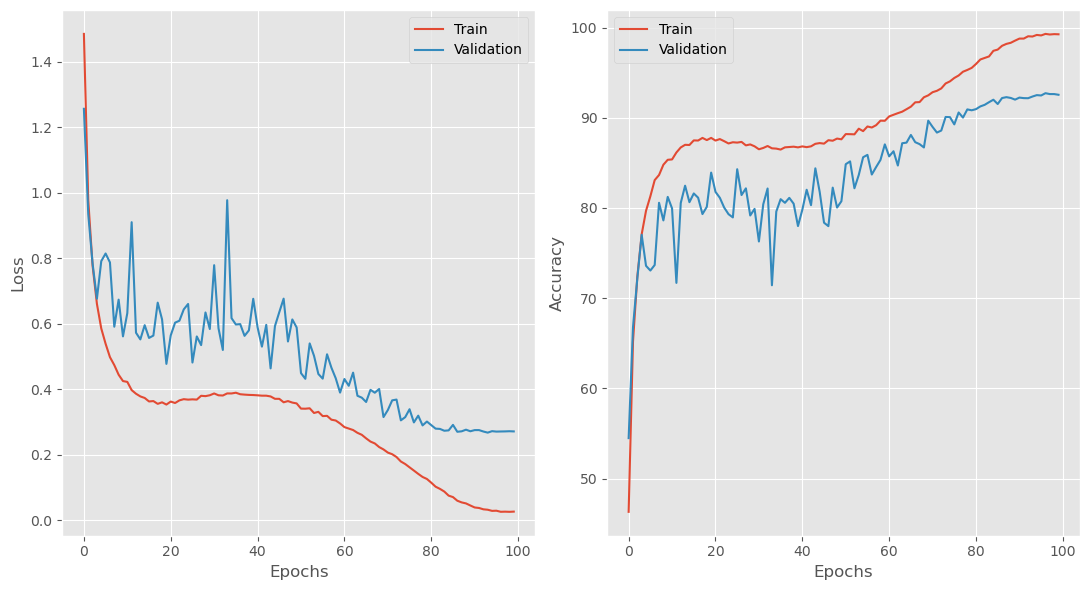

In [386]:
plt.figure(figsize=(11, 6))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses, label='Train')
plt.plot(range(len(val_losses)), val_losses, label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(train_accs)), train_accs, label='Train')
plt.plot(range(len(val_accs)), val_accs, label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.tight_layout()

Text(0, 0.5, 'learning rate value')

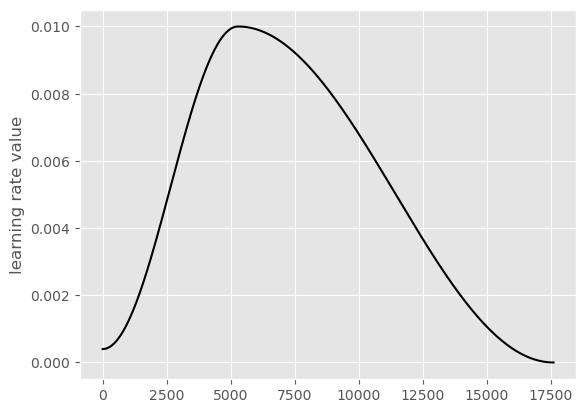

In [395]:
plt.plot(range(len(lrs)), lrs, c='k')
plt.ylabel('learning rate value')

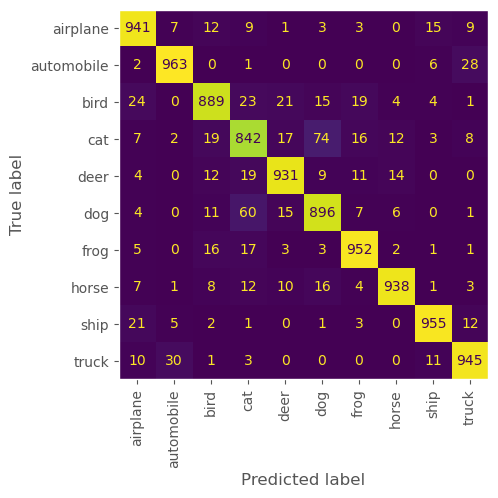

In [385]:
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=np.array(class_names))
disp.plot(xticks_rotation='vertical', colorbar=False)#, cmap='Blues')
plt.grid(False)

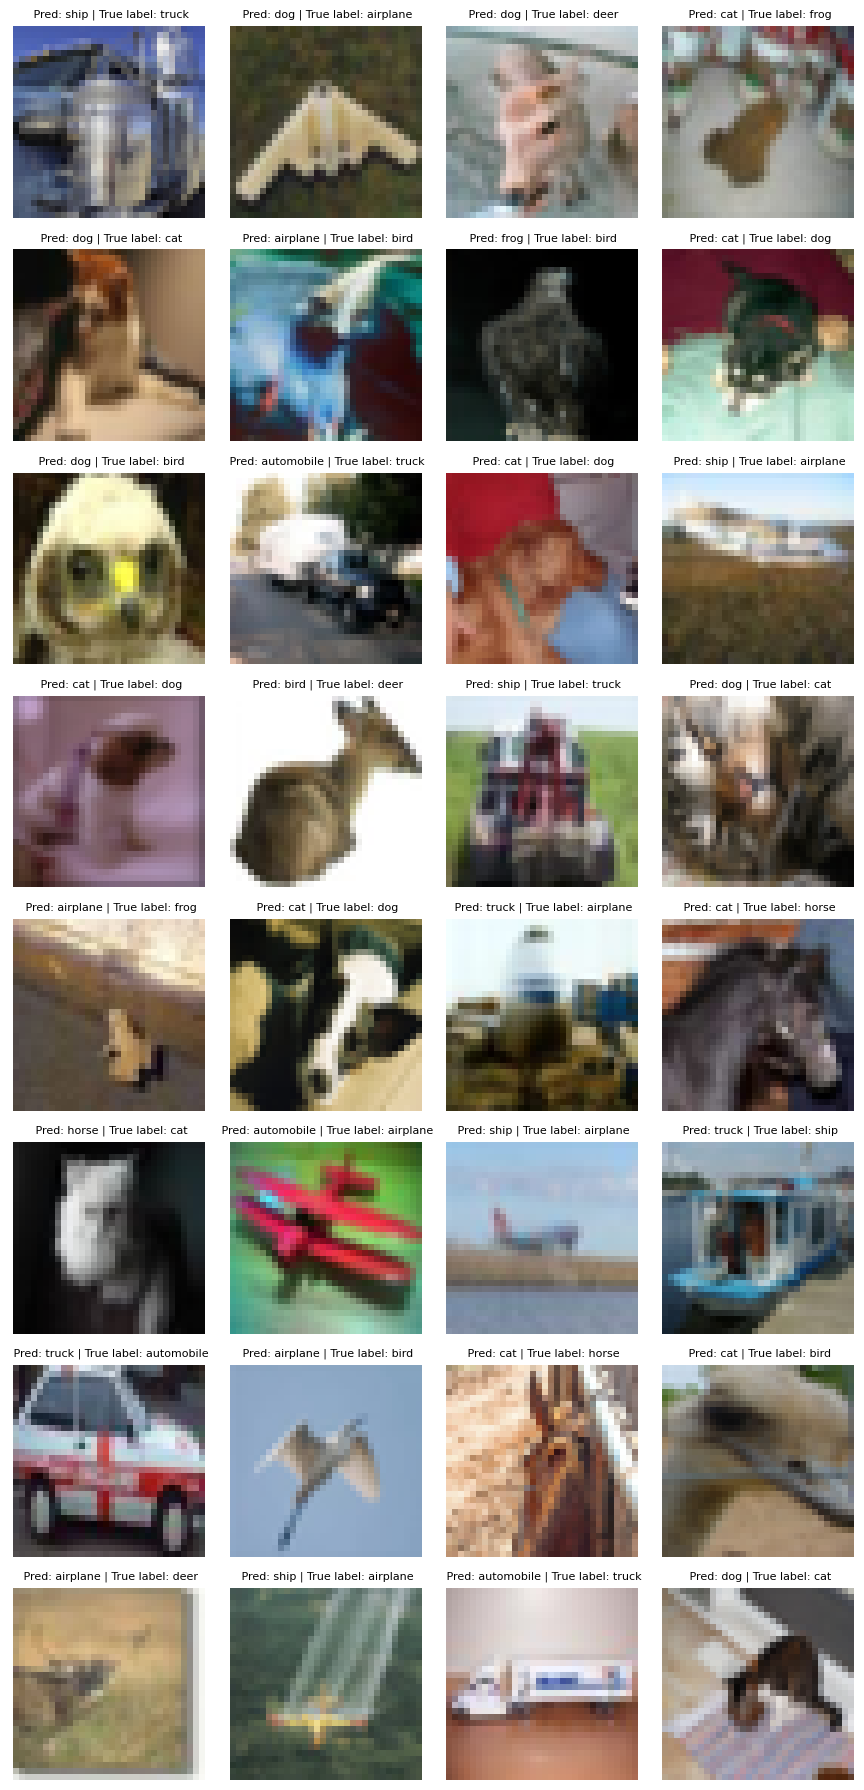

In [388]:
plot_some_mistakes(cifar10_test_data, labels, preds, class_names)